In [1]:
# Imports
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

In [2]:
# Default plot parameters
font = {'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
legend_fs = 16

N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,1,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'

<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_20616\1870376016.py:40: SyntaxWarning: invalid escape sequence '\m'
  ax_surf[t_pidx].set_ylabel('$t_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_20616\1870376016.py:63: SyntaxWarning: invalid escape sequence '\m'
  ax_surf[w_pidx].set_ylabel('$w_b^y$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_20616\1870376016.py:64: SyntaxWarning: invalid escape sequence '\m'
  ax_surf[w_pidx].set_xlabel('$w_b^x$ ($\mu$m)')


Membrane A geometry: 
Thickness = 2.44 ± 0.01 μm 
Width = 277 ± 118 μm

Membrane B geometry: 
Thickness = 1.25 ± 0.05 μm 
Width = 346 ± 118 μm



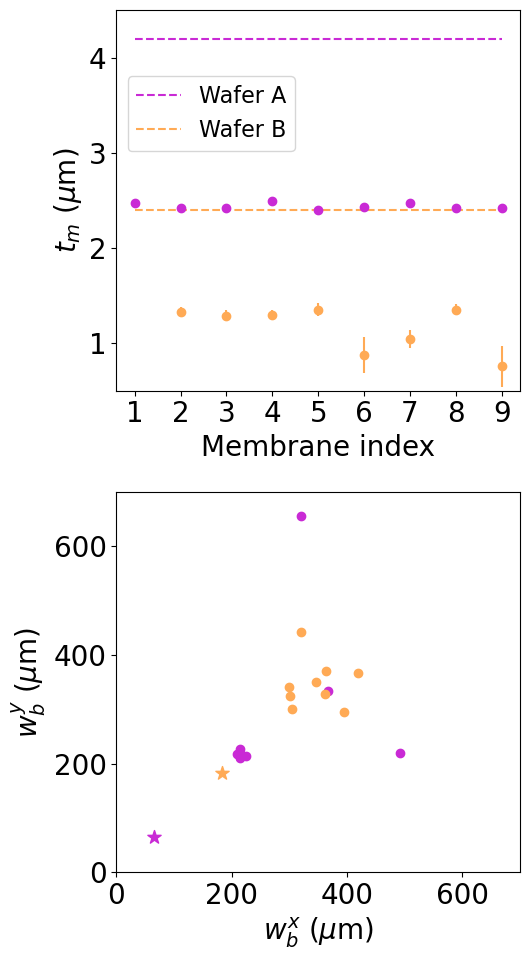

In [70]:
# Membrane widths (optical microscopy)
w_b_A = pd.read_csv(r"Raw_data\membrane_widths_waferA.csv")
w_b_B = pd.read_csv(r"Raw_data\membrane_widths_waferB.csv")

# Membrane thicknesses (ellipsometry)
t_popt_A = np.loadtxt('membraneA_thickness.txt')
t_perr_A = np.loadtxt('membraneA_thickness_error.txt')
t_mem_A = np.sum(t_popt_A,axis=1)
t_err_A = np.sqrt(np.sum(t_perr_A**2, axis=1))

t_popt_B = np.loadtxt('membraneB_thickness.txt')
t_perr_B = np.loadtxt('membraneB_thickness_error.txt')
t_mem_B = np.sum(t_popt_B,axis=1)
t_err_B = np.sqrt(np.sum(t_perr_B**2, axis=1))

# Predicted geometry (etch model - see Fig2.ipynb) 
predicted_geometry = np.loadtxt("predicted_geometry.txt")

## Plots ## 
fig_surf, ax_surf = plt.subplots(2,1, figsize=(5.7,10))
t_pidx = 0
w_pidx = 1

# Plot thicknesses
x_mem = range(1,len(t_mem_A)+1)
ax_surf[t_pidx].errorbar(range(1,len(t_mem_A)+1), 1e-3*t_mem_A, 
                    yerr=1e-3*t_err_A, 
                    capsize=0, marker='o', markersize=6, ls='none',
                    color=color_cycle[2])
ax_surf[t_pidx].plot(x_mem, predicted_geometry[0][0]*np.ones((len(x_mem))), '--', color=color_cycle[2])
ax_surf[t_pidx].errorbar(x_mem[1::], 1e-3*np.flip(t_mem_B), 
                    yerr=1e-3*np.flip(t_err_B), 
                    capsize=0, marker='o', markersize=6, ls='none',
                    color=color_cycle[3])
# ax_surf[t_pidx].errorbar(range(1,len(t_mem_B)+1), 1e-3*t_mem_B, 
                    # yerr=1e-3*t_err_B, 
                    # capsize=0, marker='o', markersize=6, ls='none',
                    # color=color_cycle[3])
ax_surf[t_pidx].plot(x_mem, predicted_geometry[1][0]*np.ones((len(x_mem))), '--', color=color_cycle[3])
ax_surf[t_pidx].set_ylabel('$t_m$ ($\mu$m)')
ax_surf[t_pidx].legend(['Wafer A', 'Wafer B'], loc='best', fontsize=legend_fs, ncol=1, 
                       bbox_to_anchor=(0.0, 0.6, 0.5, 0.5))
ax_surf[t_pidx].set_ylim([0.5,4.5])

ax_surf[t_pidx].set_xticks(range(1,10), labels=[str(x) for x in range(1,10)])
ax_surf[t_pidx].set_xlabel('Membrane index')

# Plot widths
ax_surf[w_pidx].scatter(w_b_A.iloc[:,1], w_b_A.iloc[:,2], 
                color=color_cycle[2], label='Wafer A')
ax_surf[w_pidx].scatter(predicted_geometry[0][1], predicted_geometry[0][1], 100, marker='*', 
                        color=color_cycle[2], 
                        )
ax_surf[w_pidx].scatter(w_b_B.iloc[:,1], w_b_B.iloc[:,2], 
                color=color_cycle[3], label='Wafer B')
ax_surf[w_pidx].scatter(predicted_geometry[1][1], predicted_geometry[1][1], 100, marker='*', 
                        color=color_cycle[3], 
                        )


ax_surf[w_pidx].set_xlim([0,700])
ax_surf[w_pidx].set_ylim([0,700])
ax_surf[w_pidx].set_ylabel('$w_b^y$ ($\mu$m)')
ax_surf[w_pidx].set_xlabel('$w_b^x$ ($\mu$m)')

fig_surf.tight_layout()

def calculate_weighted_error(t_mem, t_err):
    """
    Calculates the weighted error including both measurement noise and random effects (process variation) between membranes
    
    Arguments: 
        t_mem : measured membrane thicknesses
        t_err : measurement (fit) noise
    
    Returns:
        t_mem_prime : weighted random-effects mean
        t_err_prime : weighted random-effects error
    """
    t_weighted_mean = np.sum(t_mem / (t_err**2)) / np.sum(1 / (t_err**2))
    # Cochran's Q statistic (measures sample/membrane inhomogeneity)
    Q = np.sum((t_mem - t_weighted_mean)**2 / (t_err**2))
    # Estimated true membrane-to-membrane standard deviation
    tau_sq = (Q - (len(t_mem) - 1)) / (np.sum(1 / t_err**2) - np.sum(1/t_err**4) / np.sum(1/t_err**2))
    # Update weights with random effects contribution
    weights_prime = 1 / (t_err**2 + tau_sq)
    t_mem_prime = np.sum(weights_prime * t_mem) / np.sum(weights_prime)
    t_err_prime = np.sqrt(1/np.sum(weights_prime))
    return t_mem_prime, t_err_prime

t_mem_prime_A, t_err_prime_A = calculate_weighted_error(t_mem_A, t_err_A)
t_mem_prime_B, t_err_prime_B = calculate_weighted_error(t_mem_B, t_err_B)

w_b_list_A = list(w_b_A.iloc[:,1]) + list(w_b_A.iloc[:,2])
w_b_list_B = list(w_b_B.iloc[:,1]) + list(w_b_B.iloc[:,2])

# Print measured membrane geometries
print(f"Membrane A geometry: \nThickness = {t_mem_prime_A/1e3:.2f} ± {t_err_prime_A/1e3:.2f} μm \nWidth = {np.mean(w_b_list_A):.0f} ± {np.std(w_b_list_A):.0f} μm\n")
print(f"Membrane B geometry: \nThickness = {t_mem_prime_B/1e3:.2f} ± {t_err_prime_B/1e3:.2f} μm \nWidth = {np.mean(w_b_list_B):.0f} ± {np.std(w_b_list_A):.0f} μm\n")

np.savetxt("measured_geometries.txt",[
    t_mem_prime_A/1e3, 
    t_err_prime_A/1e3, 
    np.mean(w_b_list_A), 
    np.std(w_b_list_A), 
    t_mem_prime_B/1e3, 
    t_err_prime_B/1e3, 
    np.mean(w_b_list_B), 
    np.std(w_b_list_B)
   ]
)